## Imports

In [30]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing

In [31]:
def plot_letters(X, Y):
    for i in range(20):
        plt.subplot(5, 4, i + 1)
        plt.tight_layout()
        plt.imshow(X[i].reshape(32, 32), cmap='gray')
        plt.title('Label : {}'.format(Y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
df_train = pd.read_csv('data/train.txt', sep=" ", header=0)
df_test = pd.read_csv('data/validation.txt', sep=" ", header=0)
df_comp = pd.read_csv('data/competition.txt', sep=" ", header=0)

X_train = df_train.iloc[:, 1:]
Y_train = df_train.iloc[:, 0]

X_test = df_test.iloc[:, 1:]
Y_test = df_test.iloc[:, 0]

X_comp = np.array(df_comp)
X_comp = X_comp.reshape((X_comp.shape[0], 32, 32, 1))

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = Y_test.to_numpy()

# Z-score normalization
mean = np.mean(X_train, axis=(0, 1))
std = np.std(X_train, axis=(0, 1))
X_train = ((X_train - mean) / (std + 1e-7)).astype("float32")
X_test = ((X_test - mean) / (std + 1e-7)).astype("float32")
X_comp = ((X_comp - mean) / (std + 1e-7)).astype("float32")

# Labels conversion
Y_train[Y_train == 1] = 0
Y_train[Y_train == 2] = 1
Y_train[Y_train == 6] = 2
Y_train[Y_train == 12] = 3
Y_train[Y_train == 16] = 4
Y_train[Y_train == 18] = 5
Y_train[Y_train == 22] = 6

y_test[y_test == 1] = 0
y_test[y_test == 2] = 1
y_test[y_test == 6] = 2
y_test[y_test == 12] = 3
y_test[y_test == 16] = 4
y_test[y_test == 18] = 5
y_test[y_test == 22] = 6

nr_classes = len(np.unique(df_train.iloc[:, 0]))
print("Number of classes : ", nr_classes)

X_train = X_train.reshape(1444, 32, 32, 1)
y_train = keras.backend.one_hot(Y_train, nr_classes)
y_train = y_train.numpy().reshape(1444, 7)

X_test = X_test.reshape(256, 32, 32, 1)
y_test = keras.backend.one_hot(y_test, nr_classes)
y_test = y_test.numpy().reshape(256, 7)

Number of classes :  7


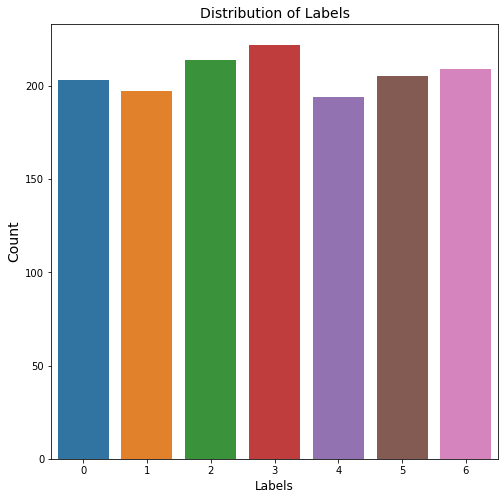

In [32]:
# Distribution
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(x=Y_train)
ax.set_title('Distribution of Labels', fontsize=14)
ax.set_xlabel('Labels', fontsize=12)
ax.set_ylabel('Count', fontsize=14)
plt.show()

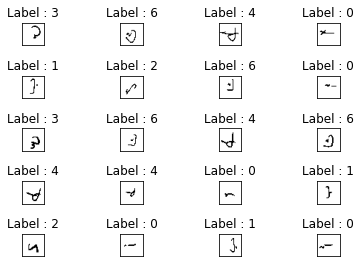

In [34]:
plot_letters(X_train, Y_train)

## Model implementation

In [35]:
model = Sequential()
# C1 Convolutional Layer
model.add(Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh',
                 input_shape=(32, 32, 1), padding='same'))

# S2 Pooling Layer
model.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh',
                 padding='valid'))
# S4 Pooling Layer
model.add(AveragePooling2D(pool_size=2, strides=2, padding='valid'))

# C5 Convolutional Layer
model.add(Conv2D(filters=120, kernel_size=5, strides=1, activation='tanh',
                 padding='valid'))

# Flatten the CNN output to feed it with fully connected layers
model.add(Flatten())

# FC6 Fully Connected Layer
model.add(Dense(units=84, activation='tanh'))

# FC7 Output layer with softmax activation
model.add(Dense(units=7, activation='softmax'))

print(model.summary())

adam = Adam(lr=5e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 6)         156       
_________________________________________________________________
average_pooling2d_6 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_7 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 120)         48120     
_________________________________________________________________
flatten_3 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

In [39]:
# Data augmentation (train & validation)
validation_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
validation_datagen.fit(X_test)

train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
train_datagen.fit(X_train)

In [40]:
hist = model.fit(train_datagen.flow(X_train, y_train, batch_size=100), epochs=100,
                 validation_data=validation_datagen.flow(X_test, y_test, batch_size=100),
                 shuffle=True)

Epoch 1/100
15/15 [==============================] - 1s 46ms/step - loss: 1.7787 - accuracy: 0.2988 - val_loss: 1.4566 - val_accuracy: 0.4609
Epoch 2/100
15/15 [==============================] - 1s 34ms/step - loss: 1.2845 - accuracy: 0.5133 - val_loss: 1.1549 - val_accuracy: 0.5898
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 1.1660 - accuracy: 0.5695 - val_loss: 1.0977 - val_accuracy: 0.6289
Epoch 4/100
15/15 [==============================] - 1s 35ms/step - loss: 1.1033 - accuracy: 0.6091 - val_loss: 1.1073 - val_accuracy: 0.5703
Epoch 5/100
15/15 [==============================] - 1s 34ms/step - loss: 1.0255 - accuracy: 0.6023 - val_loss: 1.0758 - val_accuracy: 0.6250
Epoch 6/100
15/15 [==============================] - 1s 35ms/step - loss: 1.0101 - accuracy: 0.6484 - val_loss: 1.0222 - val_accuracy: 0.6484
Epoch 7/100
15/15 [==============================] - 1s 37ms/step - loss: 0.9623 - accuracy: 0.6544 - val_loss: 0.9765 - val_accuracy: 0.6680
Epoch 

15/15 [==============================] - 1s 38ms/step - loss: 0.1168 - accuracy: 0.9645 - val_loss: 0.1644 - val_accuracy: 0.9453
Epoch 59/100
15/15 [==============================] - 1s 35ms/step - loss: 0.1012 - accuracy: 0.9732 - val_loss: 0.1717 - val_accuracy: 0.9414
Epoch 60/100
15/15 [==============================] - 1s 35ms/step - loss: 0.1198 - accuracy: 0.9567 - val_loss: 0.1833 - val_accuracy: 0.9297
Epoch 61/100
15/15 [==============================] - 1s 36ms/step - loss: 0.1041 - accuracy: 0.9695 - val_loss: 0.1602 - val_accuracy: 0.9453
Epoch 62/100
15/15 [==============================] - 1s 37ms/step - loss: 0.1199 - accuracy: 0.9627 - val_loss: 0.1578 - val_accuracy: 0.9531
Epoch 63/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0989 - accuracy: 0.9632 - val_loss: 0.1701 - val_accuracy: 0.9336
Epoch 64/100
15/15 [==============================] - 1s 36ms/step - loss: 0.1011 - accuracy: 0.9711 - val_loss: 0.1704 - val_accuracy: 0.9375
Epoch 65/100

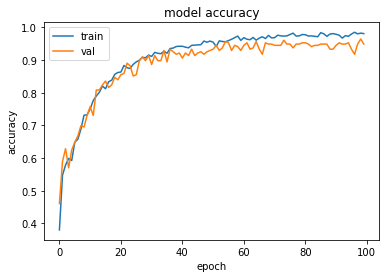

In [41]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Kaggle Data predictions

In [42]:
# Predictions on Kaggle data
Y_comp = np.argmax(model.predict(X_comp), axis=-1)

# Revert back the labels
Y_comp[Y_comp == 6] = 22
Y_comp[Y_comp == 5] = 18
Y_comp[Y_comp == 4] = 16
Y_comp[Y_comp == 3] = 12
Y_comp[Y_comp == 2] = 6
Y_comp[Y_comp == 1] = 2
Y_comp[Y_comp == 0] = 1

df_out = pd.read_csv('data/sample.csv')
df_out['label'] = Y_comp
print(df_out.head())
df_out.to_csv('data/out.csv', index=False)

   Id  label
0   1     22
1   2     16
2   3     16
3   4     16
4   5     16
